In [37]:
from random import random
import numpy as np

In [38]:
def get_random_points(n):
    return np.random.uniform(-1, 1, [n, 2])

def get_random_line_vector():
    rp = np.random.uniform(-1, 1, (2, 2)) 
    slope = (rp[0, 1] - rp[1, 1]) / (rp[0, 0] - rp[1, 0])
    intercept = rp[0, 1] - rp[0, 0] * slope
    return [intercept, slope, 1]    

def get_labels(pi, vector):
    labels = np.sign(np.dot(pi, vector))
    return labels

def add_intercept(points):
    pi = np.array([[1, x1, x2] for (x1, x2) in points])
    return pi

In [39]:
def get_initial_w():
    w = np.array([0, 0 , 0.001])
    return w

In [40]:
def get_perceptron_predictions(pi, labels, w):
    return np.sign(np.dot(pi, w)) == labels

def update_w(w, mp, label):
    return w + label*mp

In [41]:
from itertools import count

def train_perceptron(pi, labels, w): 
    for num_iterations in count(start=0, step=1):    
        predictions = get_perceptron_predictions(pi, labels, w)

        if predictions.all():
            break

        missclassified_points_indexes = np.where(predictions==False)[0]
        k = np.random.choice(missclassified_points_indexes, 1)[0]
        w = update_w(w, pi[k], labels[k])
#         print(w)
    return w, num_iterations

In [75]:
N_TEST = 10000
points_test = get_random_points(N_TEST) # hack for speed
pi_test = add_intercept(points_test)

def evaluate_solution(w, fx_vector):
    labels_test = get_labels(pi_test, fx_vector)
    return get_perceptron_predictions(pi_test, labels_test, w).sum() / N_TEST

# SVM

In [103]:
def fit_svm(x, y):
    NUM = x.shape[0]
    DIM = x.shape[1]
    # we'll solve the dual
    # obtain the kernel
    K = y[:, None] * x
    K = np.dot(K, K.T)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

In [273]:
def get_w_svm(alphas, points, labels):
    # get weights
    w_svm = np.sum(alphas * labels[:, None] * points, axis = 0)
    # get bias
    cond = (alphas > 1e-4).reshape(-1)
    b = labels[cond] - np.dot(points[cond], w_svm)
    bias = b[0]

    # normalize
    norm = np.linalg.norm(w_svm)
    w_svm_norm, bias_norm = w_svm / norm, bias / norm

    w_svm_final = [bias_norm, w_svm_norm[0], w_svm_norm[1]]
    return w_svm_final

# Compare Perceptron to SVM

In [277]:
def run_experiment(n):
    # create points
    points = get_random_points(n)
    pi = add_intercept(points)
    while True:
        fx_vector = get_random_line_vector()
        labels = get_labels(pi, fx_vector)
        if (labels < 0).any() and (labels > 0).any():
            break
    
    # train & evaluate pereceptron
    w_perceptron = get_initial_w()
    w_perceptron, iterations = train_perceptron(pi, labels, w_perceptron)
    acc_perceptron = evaluate_solution(w_perceptron, fx_vector)
    
    # train & evaluate svm
    alphas = fit_svm(points, labels)
    w_svm = get_w_svm(alphas, points, labels)
    acc_svm = evaluate_solution(w_svm, fx_vector)
    
    return acc_svm > acc_perceptron, sum(alphas > 1e-4)[0]

In [278]:
RUNS = 1000
N  = 10
c = 0
a = 0

for i in range(RUNS):
    ci, ai = run_experiment(N)
    c+=ci
    a+=ai

print(c/RUNS)
print(a/RUNS)

0.632
2.843


In [279]:
RUNS = 1000
N  = 100
c = 0
a = 0

for i in range(RUNS):
    ci, ai = run_experiment(N)
    c+=ci
    a+=ai

print(c/RUNS)
print(a/RUNS)

0.651
3.019


# Visualize

In [280]:
import matplotlib.pyplot as plt

DIM = 2
COLORS = ['red', 'blue']

def plot_data_with_labels(x, y, ax):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])

In [281]:
# def plot_svm_separator(ax, w_svm_norm, bias_norm):
#     slope = -w[0] / w[1]
#     intercept = -b / w[1]
#     x = np.arange(-1, 2)
#     ax.plot(x, x * slope + intercept, 'k-')

In [282]:
def get_plot_points_from_vector(vector):
    x = np.array([-1, 1])
    y = (- vector[1] * x - vector[0]) / vector[2]
    return (x, y)

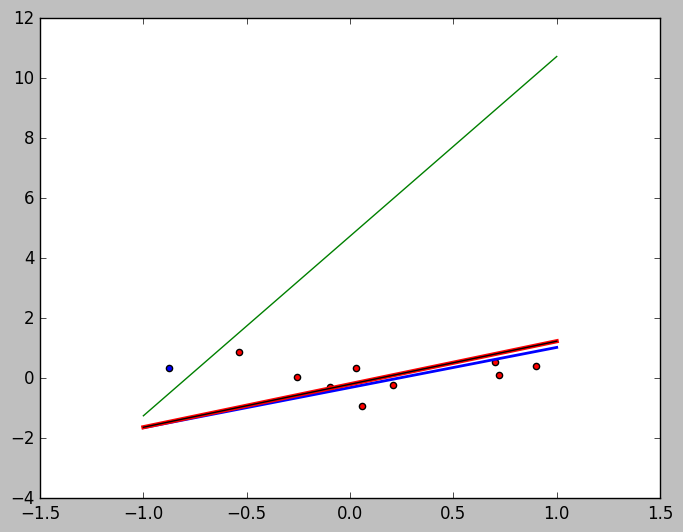

In [283]:
fig, ax = plt.subplots()
# plot_separator(ax, w, 0)
plot_data_with_labels(points, labels, ax)

lx, ly  = get_plot_points_from_vector(fx_vector)
ax.plot(lx, ly, 'g', lw=1)

lx, ly  = get_plot_points_from_vector(w)
ax.plot(lx, ly, 'b', lw=2)

lx, ly  = get_plot_points_from_vector(w_s)
ax.plot(lx, ly, 'r', lw=3)

# show data and w
plot_separator(ax, w_svm_norm, bias_norm)